# I. Massachusetts Ranked Choice Voting 2020

Massachusetts' 2020 general elections featured two ballot measures, one of which proposed the statewide use of [Ranked Choice Voting](https://ballotpedia.org/Massachusetts_Question_2,_Ranked-Choice_Voting_Initiative_(2020)) (RCV). Ranked Choice Voting is a democratic reform with several design advantages over the common and currently used winner-take-all method. It prevents the [spoiler effect](https://www.youtube.com/watch?v=3Y3jE3B8HsE) and [disincentivizes negative campaigning.](https://www.jstor.org/stable/10.1002/naticivirevi.106.1.0025?seq=1) Ranked Choice Voting has, to this point, been relatively rare in American elections, having been implemented at the statewide level only in [Maine](https://www.maine.gov/sos/cec/elec/upcoming/rankedchoicefaq.html) and [Alaska.](https://www.vox.com/2020/11/19/21537126/alaska-measure-2-ranked-choice-voting-results) Massachusetts has led the nation on progressive issues before, having been the [first to legalize gay marriage](https://www.bostonglobe.com/2020/01/28/opinion/how-did-gay-marriage-happen-massachusetts-first-judicial-independence/) and the [first to mandate universal healthcare coverage.](https://www.bostonglobe.com/2020/01/28/opinion/how-massachusetts-became-national-leader-healthcare-how-it-can-lead-again/) This makes the commonwealth a promising place to see Ranked Choice Voting implemented.

However, the initiative failed when it was put to a vote, perhaps unexpectedly. [Massachusetts went for Biden by 33 points](https://www.wbur.org/news/2020/11/03/2020-massachusetts-election-map). The Yes on 2 (pro-Ranked Choice Voting) campaign was [well funded](https://ballotpedia.org/Massachusetts_Question_2,_Ranked-Choice_Voting_Initiative_(2020)), made up of a [broad coalition,](https://www.yeson2rcv.com/endorsements/) and faced relatively little organized opposition (most notably from [Governor Charlie Baker](https://www.boston.com/news/politics/2020/10/27/charlie-baker-ranked-choice-voting-massachusetts-question-2)). Why didn't it succeed?

Let's see if we can find any hints in the data.

# II. The Data

In [1]:
# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import shapefile as shp
import statsmodels.api as sm
import statsmodels.stats.weightstats as smw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings

The election results are publicly available from the [Massachusetts Secretary of State's website.](https://electionstats.state.ma.us/) I downloaded the results from the four decisions put to voters statewide:
1. [President](https://electionstats.state.ma.us/elections/view/140751/)
2. [Senate](https://electionstats.state.ma.us/elections/view/140755/)
3. [Question 1: Right to Repair](https://electionstats.state.ma.us/ballot_questions/view/7343/)
4. [Question 2: Ranked Choice Voting](https://electionstats.state.ma.us/ballot_questions/view/7344/)

In [2]:
def extract_data_from_massachusetts_election_results(data_ffile):
    
    data_csv_loaded = pd.read_csv(data_ffile)
    normalized_data_by_town = {}
    total_votes_by_town = {}
    total_votes = []
    cols = data_csv_loaded.columns
    
    for i in range(len(data_csv_loaded)):
        town_row = data_csv_loaded.loc[i]
        town = town_row[0]
        if type(town) is not str:
            continue
        town = town.replace('N.','North')
        town = town.replace('S.','South')
        town = town.replace('E.','East')
        town = town.replace('W.','West')
        total_votes.append(town_row[-1])
        option1_count_str = town_row[3]
        option1_count_str = option1_count_str.replace(',','')
        option1_count = int(option1_count_str)
        option2_count_str = town_row[4]
        option2_count_str = option2_count_str.replace(',','')
        option2_count = int(option2_count_str)
        option2_fraction = (option2_count) / (option1_count + option2_count)
        normalized_data_by_town[town.upper()] = option2_fraction
        total_votes_row = town_row[-1].replace(',','')
        total_votes_by_town[town.upper()] = int(total_votes_row)
    normalized_data_by_town['MANCHESTER'] = normalized_data_by_town['MANCHESTER-BY-THE-SEA']
    del normalized_data_by_town['MANCHESTER-BY-THE-SEA']
    del normalized_data_by_town['TOTALS']
    
    total_votes_by_town['MANCHESTER'] = total_votes_by_town['MANCHESTER-BY-THE-SEA']
    del total_votes_by_town['MANCHESTER-BY-THE-SEA']
    del total_votes_by_town['TOTALS']
    
    total_votes = list(total_votes_by_town.values())
    max_votes = max(total_votes)
    
    weights_by_town = {}
    for town in total_votes_by_town:
        weights_by_town[town] = total_votes_by_town[town] / max_votes
    
    return normalized_data_by_town, weights_by_town, total_votes_by_town

I also wanted to be able to compare the election data to possible explanatory demographic factors. I downloaded the following demographic information for every Massachusetts municipality in 2018 from the [US census website](https://data.census.gov/cedsci/):
1. [Educational attainment for the population 25 years and older](https://data.census.gov/cedsci/table?q=ACSDT5Y2018.B15003&g=0400000US25.060000&tid=ACSDT5Y2018.B15003&hidePreview=true) (search code: ACSDT5Y2018.B15003)
2. [Median household income in the past 12 months (in 2018 inflation-adjusted dollars)](https://data.census.gov/cedsci/table?q=ACSDT5YAIAN2018.B19013&g=0400000US25.060000&tid=ACSDT5Y2018.B19013&hidePreview=true) (search code: ACSDT5YAIAN2018.B19013)
3. [Race](https://data.census.gov/cedsci/table?q=ACSDT5Y2018.B02001&g=0400000US25.060000&tid=ACSDT5Y2018.B02001&hidePreview=true) (search code: ACSDT5Y2018.B02001)
4. [Median age by sex](https://data.census.gov/cedsci/table?q=ACSDT5YAIAN2018.B01002&g=0400000US25.060000&tid=ACSDT5Y2018.B01002&hidePreview=true) (search code: ACSDT5YAIAN2018.B01002)

In [3]:
def extract_data_from_US_census(census_csv_loaded,factor_name):
    
    factor_data_types = {'age': 'continuous',
                         'education': 'categorical',
                         'income': 'continuous',
                         'race': 'categorical'}
    
    data_type = factor_data_types[factor_name]
    
    # If the data is categorical, we need to sort it into two groups
    if data_type == 'categorical':
        [normalized_factor_by_town, raw_factor_by_town, factor_limits, colorbar_label] = extract_data_from_US_census_categorical(census_csv_loaded,factor_name)    
    if data_type == 'continuous':
        [normalized_factor_by_town, raw_factor_by_town, factor_limits, colorbar_label] = extract_data_from_US_census_continuous(census_csv_loaded,factor_name)
        
    # Reconcile lone discrepancy between town names in Census and Shapes data
    normalized_factor_by_town['MANCHESTER'] = normalized_factor_by_town['MANCHESTER-BY-THE-SEA']
    raw_factor_by_town['MANCHESTER'] = raw_factor_by_town['MANCHESTER-BY-THE-SEA']
    return normalized_factor_by_town, raw_factor_by_town, factor_limits, colorbar_label

In [4]:
def extract_data_from_US_census_categorical(census_csv_loaded,factor_name):
    import re
    cols = census_csv_loaded.columns

    normalized_factor_by_town = {}
    raw_factor_by_town = {}
    for town_count in range(1,len(census_csv_loaded)):
        town_row = census_csv_loaded.loc[town_count]


        towns_list_from_data = []
        town = town_row['NAME']
        town_only = town.split(',')[0]
        no_town = town_only.replace(' town','')
        no_Town = no_town.replace(' Town','')
        no_city = no_Town.replace(' city','')
        town_name_only = no_city.strip()
        if (town_name_only == 'County subdivisions not defined'):
            continue
        towns_list_from_data.append(town_name_only)


        group0_count = 0
        group1_count = 0

        for i in range(len(cols)):
            field = cols[i]
            data = town_row[i]

            # Education-specific rules
            if bool(re.match('B15003_...E',field)):
                field_estimate_number = field.split('_')[1]
                field_number = int(field_estimate_number.replace('E',''))
                if field_number != 1:
                    #print(data)
                    if field_number < 21:
                        group0_count = group0_count + int(data) # Non-College Educated
                    else:
                        group1_count = group1_count + int(data) # College Educated
                colorbar_label = r'Colledge Educated [%]'
                factor_limits = (0,100)


            # Race-specific rules
            if bool(re.match('B02001_...E',field)):
                field_estimate_number = field.split('_')[1]
                field_number = int(field_estimate_number.replace('E',''))
                if field_number != 1:
                    if field_number != 2:
                        group1_count = group1_count + int(data) # Nonwhite
                    else:
                        group0_count = group0_count + int(data) # White
                colorbar_label = r'Non-white [%]'
                factor_limits = (0,100)

        factor_fraction = (group1_count)/(group0_count + group1_count)
        normalized_factor_by_town[town_name_only.upper()] = factor_fraction
        raw_factor_by_town = normalized_factor_by_town
    return normalized_factor_by_town, raw_factor_by_town, factor_limits, colorbar_label

In [5]:
def extract_data_from_US_census_continuous(census_csv_loaded,factor_name):
    # Load Towns from Data
    towns = census_csv_loaded.NAME[1:]
    towns_list = towns.to_list()
    towns_list_from_data = []

    if factor_name == 'income':
        # Load Incomes
        factors = census_csv_loaded.B19013_001E[1:]
        colorbar_label = r'Median by Household [Thousands of USD]'
    if factor_name == 'age':
        # Load Ages
        factors = census_csv_loaded.B01002_001E[1:]
        colorbar_label = r'Median [Years]'

    factors_list_string = factors.to_list()
    factors_list = []


    # Process Towns and Factors into Lists
    for i in range(len(towns_list)):
        factor = factors_list_string[i]
        town = towns_list[i]
        town_only = town.split(',')[0]
        no_town = town_only.replace(' town','')
        no_Town = no_town.replace(' Town','')
        no_city = no_Town.replace(' city','')
        town_name_only = no_city.strip()
        if not (town_name_only == 'County subdivisions not defined'):
            towns_list_from_data.append(town_name_only)
            factors_list.append(float(factor))

    # Normalize Factor to Index (from 0 to 1) for plotting
    max_factor = max(factors_list)
    min_factor = min(factors_list)
    factor_limits = (min_factor, max_factor)
    if factor_name == 'income':
        factor_limits = (min_factor/1000, max_factor/1000)
    factor_index = []
    for factor in factors_list:
        factor_idx = (factor - min_factor)/(max_factor - min_factor)
        factor_index.append(factor_idx)

    # Assign Factor Index to Each Town
    normalized_factor_by_town = {}
    raw_factor_by_town = {}
    for i in range(len(towns_list_from_data)):
        normalized_factor_by_town[towns_list_from_data[i].upper()] = factor_index[i]
        raw_factor_by_town[towns_list_from_data[i].upper()] = factors_list[i]
    
    return normalized_factor_by_town, raw_factor_by_town, factor_limits, colorbar_label

In [6]:
def plot_map_fill_multiple_ids(title, municipalities, sf, 
                                               ax = None,
                                               color_vec = 'r',
                                               legend = None):

    factor_limits = legend['factor_limits']
    colorbar_label = legend['colorbar_label']
    cmap = legend['colormap']
    vote_type = legend['vote_type']
    legend_title_size = legend['legend_title_size']
    legend_label_loc = legend['legend_label_loc']
    legend_label_loc_x = legend_label_loc[0]
    legend_label_loc_y = legend_label_loc[1]
    legend_label_size = legend['legend_label_size']
    legend_tick_size = legend['legend_tick_size']
    
    # Plot municipalities
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k');
            
    # Color municipalities
    for id in municipalities:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color_vec[id]);
             
    
    ## Labels and Legend Formatting
    
    # Turn off axes
    ax.get_xaxis().set_visible(False);
    ax.get_yaxis().set_visible(False);
     
    # Insert colorbar
    cbaxes = inset_axes(ax, width="30%", height="3%", loc=3, borderpad = 10) 
    norm = mpl.colors.Normalize(vmin=factor_limits[0], vmax=factor_limits[1])    
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbaxes,orientation='horizontal')
    cbar = set_colorbar_options(cbar, colorbar_label, vote_type, legend_label_size, legend_tick_size)
    
    # Colorbar label
    ax.text(legend_label_loc_x,legend_label_loc_y,title,
        horizontalalignment='center',
        transform=ax.transAxes,
        fontsize = legend_title_size)
    
    with warnings.catch_warnings(record=True):
        fig.tight_layout();

In [7]:
def set_colorbar_options(cbar,
                        colorbar_label = 'Vote Margin',
                        vote_type = None,
                        legend_label_size = 22,
                        legend_tick_size = 18):
    cbar.set_label(colorbar_label,size=legend_label_size)
    cbar.ax.tick_params(labelsize=legend_tick_size)
    
    # Vote type presets
    if vote_type == 'DR':
        cbar.ax.set_xticklabels(['D +100','D +60','D +20','R +20','R +60','R +100'])
    elif vote_type == 'YN':
        cbar.ax.set_xticklabels(['Y +100','Y +60','Y +20','N +20','N +60','N +100'])
                    
    return cbar

In [8]:
def assign_color_vector(massachusetts_shapes, data, cmap = mpl.cm.get_cmap('Blues')):
    # Assign color vector from town polygons and age indeces

    massachusetts_towns_and_islands_count = len(massachusetts_shapes.records())

    color_vec = [None] * massachusetts_towns_and_islands_count
    for shape_i in range(massachusetts_towns_and_islands_count):
        town_from_shapes = massachusetts_shapes.records()[shape_i][0]
        town_data_point = data[town_from_shapes]
        if town_data_point == None: # Missing data
            color_vec[shape_i] = '#000000'
        else:
            color_vec[shape_i] = mpl.colors.to_hex(cmap(town_data_point))
    return color_vec

To plot maps of Massachusetts municipalities, I downloaded a set of shapefiles from the [Massachusetts Bureau of Geographic Information](https://docs.digital.mass.gov/dataset/massgis-data-community-boundaries-towns-survey-points) website.

In [9]:
# Load Town Shapes
mass_shapes_fullfile = r"townssurvey_shp\TOWNSSURVEY_POLY"
massachusetts_shapes = shp.Reader(mass_shapes_fullfile)
massachusetts_towns_and_islands_count = len(massachusetts_shapes.records())
massachusetts_shapes_index = range(massachusetts_towns_and_islands_count)

# III. Exploring the Data

## A. Massachusetts Election Results

In [10]:
vote_legend_defaults = {}
vote_legend_defaults['factor_limits'] = (0,1)
vote_legend_defaults['colorbar_label'] = 'Yes/No Margin'
vote_legend_defaults['colormap'] = mpl.cm.get_cmap('bwr')
vote_legend_defaults['vote_type'] = 'YN'
vote_legend_defaults['legend_label_loc'] = (.25,.23)
vote_legend_defaults['legend_title_size'] = 32
vote_legend_defaults['legend_label_size'] = 22
vote_legend_defaults['legend_tick_size'] = 18

### President

In [11]:
president_csv_ffile = r"PD43+__2020_President_General_Election.csv"
president_fraction_by_town, weights, population = extract_data_from_massachusetts_election_results(president_csv_ffile)
colormap = mpl.cm.get_cmap('bwr')
president_color_vec = assign_color_vector(massachusetts_shapes, president_fraction_by_town, cmap = colormap)
legend_president = vote_legend_defaults.copy()
legend_president['colorbar_label'] = 'Biden/Trump Margin'
legend_president['vote_type'] = 'DR'

### Senate

In [12]:
senate_csv_ffile = r"PD43+__2020_U_S_Senate_General_Election.csv"
senate_fraction_by_town, _ , _ = extract_data_from_massachusetts_election_results(senate_csv_ffile)
colormap = mpl.cm.get_cmap('bwr')
senate_color_vec = assign_color_vector(massachusetts_shapes, senate_fraction_by_town, cmap = colormap)
legend_senate = vote_legend_defaults.copy()
legend_senate['colorbar_label'] = 'Markey/O\'Connor Margin'
legend_senate['vote_type'] = 'DR'

### Question 1: Right to Repair

In [13]:
Q1_csv_ffile = r"PD43+__2020_Statewide_Question_1Do_you_approve_of_a_law_summarized_below_on_w.csv"
Q1_No_fraction_by_town, _ , _ = extract_data_from_massachusetts_election_results(Q1_csv_ffile)
colormap = mpl.cm.get_cmap('bwr')
Q1_color_vec = assign_color_vector(massachusetts_shapes, Q1_No_fraction_by_town, cmap = colormap)
legend_Q1 = vote_legend_defaults.copy()

### Question 2: Ranked Choice Voting

In [14]:
Q2_csv_ffile = r"PD43+__2020_Statewide_Question_2Do_you_approve_of_a_law_summarized_below_on_w.csv"
Q2_No_fraction_by_town, _ , _ = extract_data_from_massachusetts_election_results(Q2_csv_ffile)
colormap = mpl.cm.get_cmap('bwr')
Q2_color_vec = assign_color_vector(massachusetts_shapes, Q2_No_fraction_by_town, cmap = colormap)
legend_Q2 = vote_legend_defaults.copy()

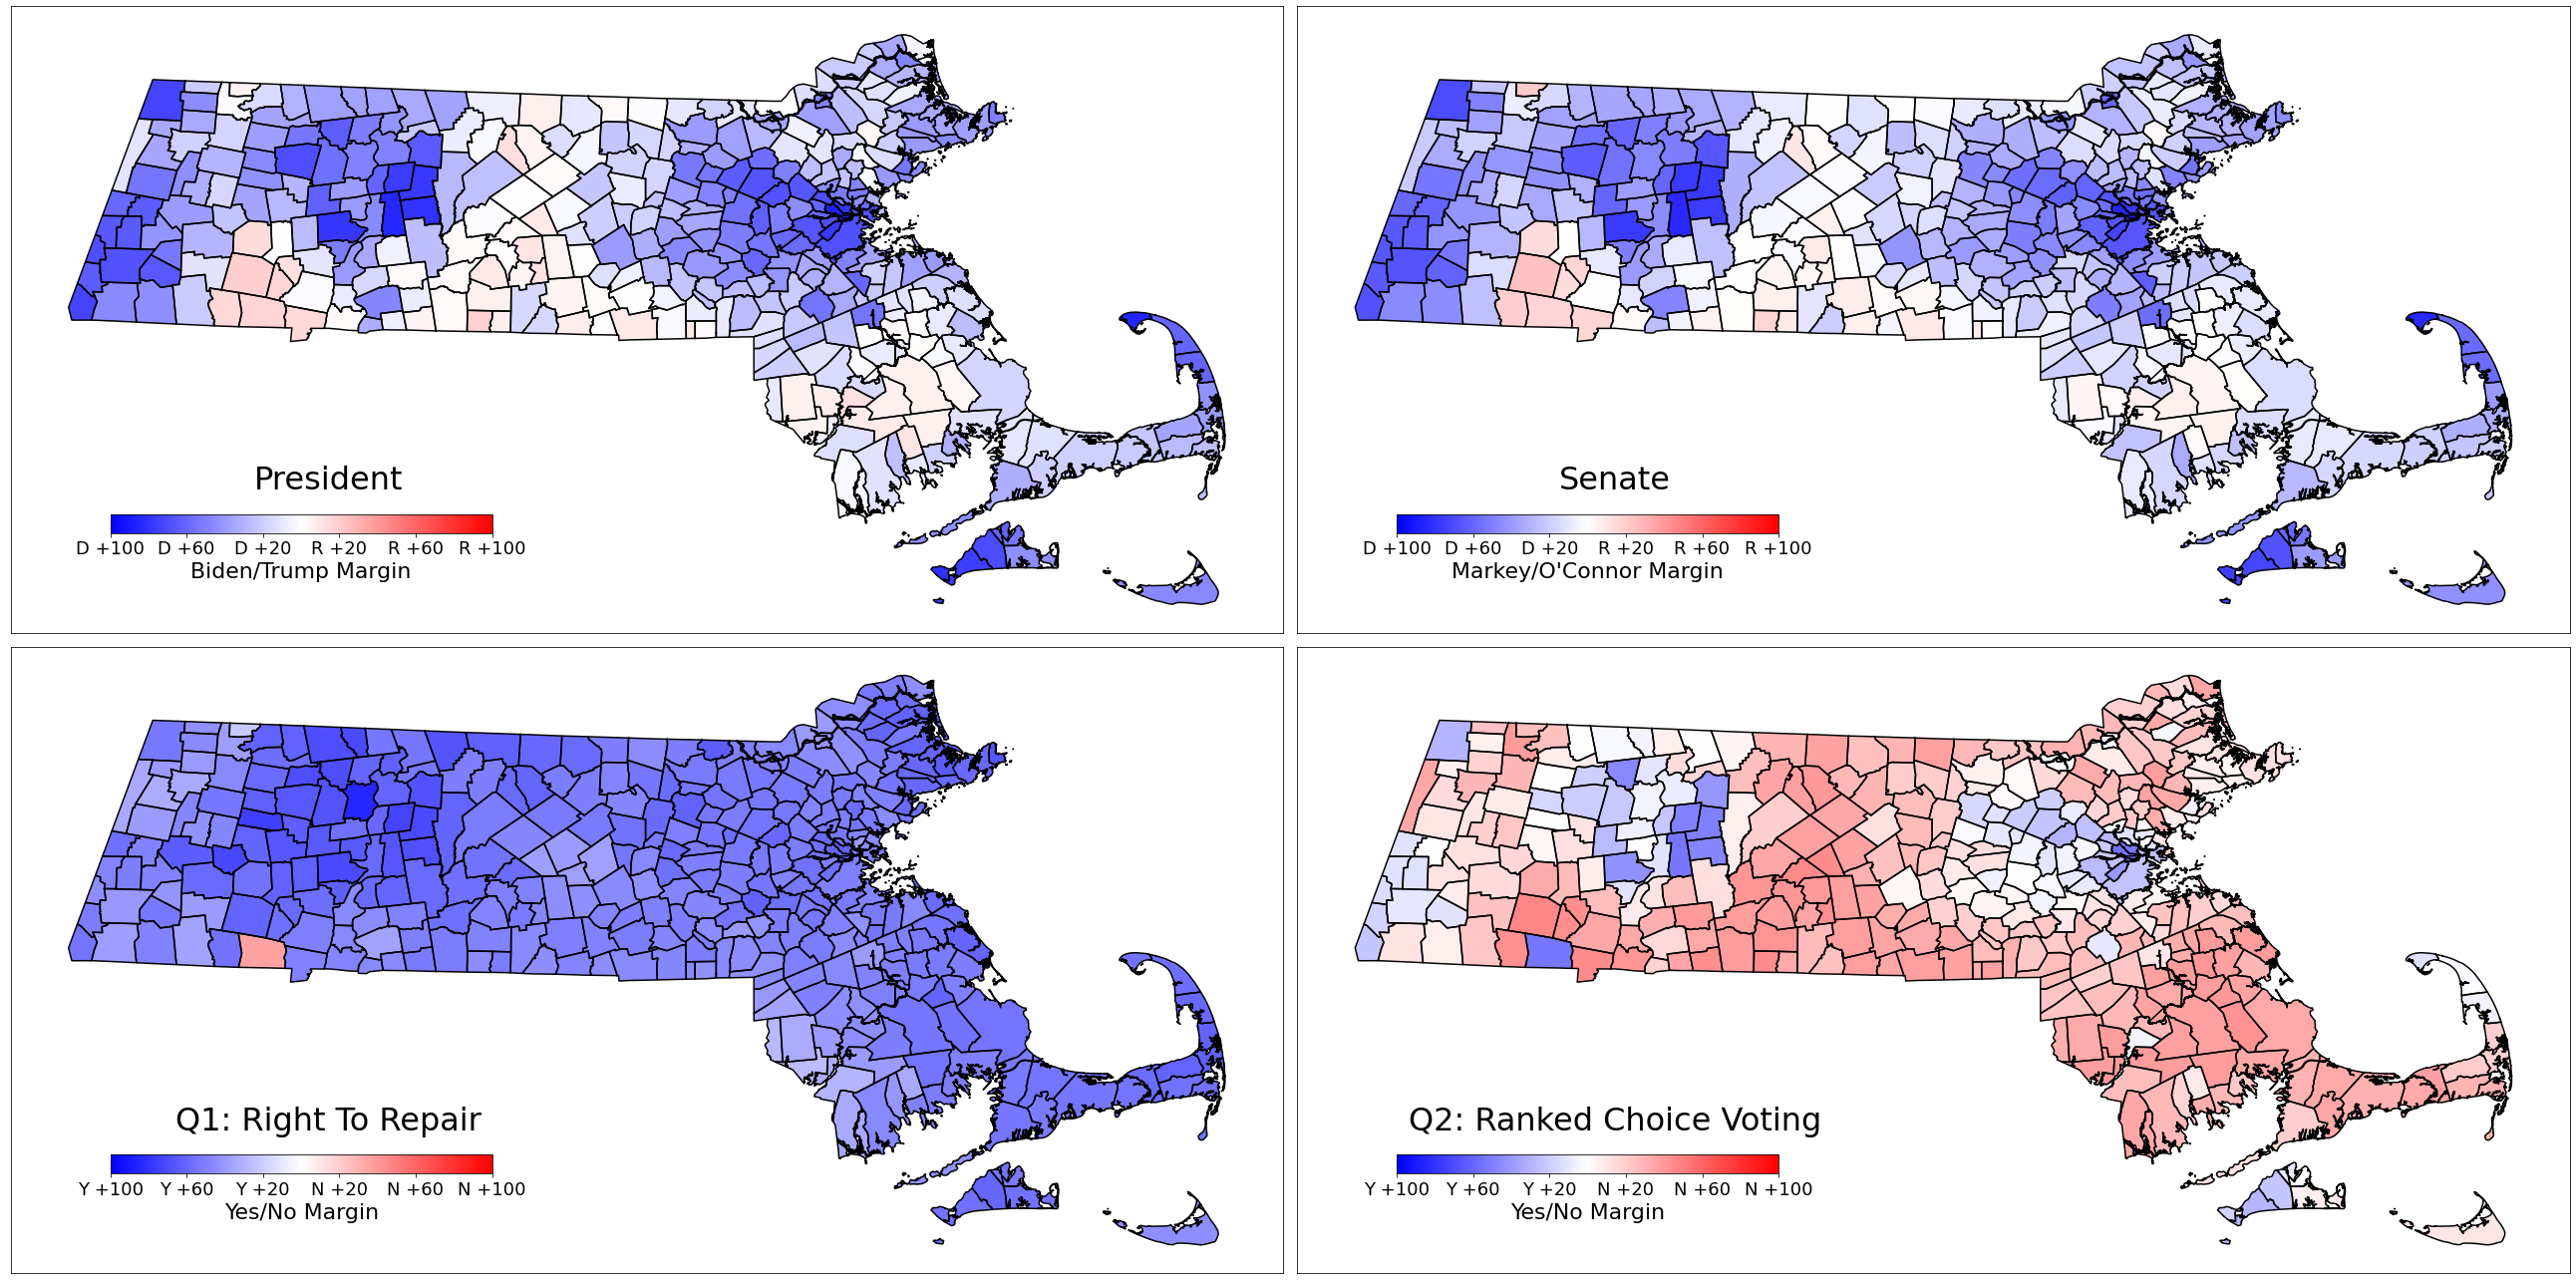

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(36,18))
plot_map_fill_multiple_ids("President", massachusetts_shapes_index, massachusetts_shapes, color_vec = president_color_vec, legend = legend_president, ax = axs[0,0])
plot_map_fill_multiple_ids("Senate", massachusetts_shapes_index, massachusetts_shapes, color_vec = senate_color_vec, legend = legend_senate, ax = axs[0,1])
plot_map_fill_multiple_ids("Q1: Right To Repair", massachusetts_shapes_index, massachusetts_shapes, color_vec = Q1_color_vec, legend = legend_Q1, ax = axs[1,0])
plot_map_fill_multiple_ids("Q2: Ranked Choice Voting", massachusetts_shapes_index, massachusetts_shapes, color_vec = Q2_color_vec, legend = legend_Q2, ax = axs[1,1])

From the electoral maps across Massachusetts, we can note several interesting results. Most significantly, Massachusetts is a Blue State. To be sure, Greater Boston and the vicinity of UMass Amherst lean Democratic, but so do the North Shore, the South Shore, the Cape and Islands, and the Berkshires to the far west. And even the red areas in the center of the state are far less red than the blue areas are blue. Also of interest is the performance of the Right to Repair initiative posed by Question 1. All across state, the measure received strong support.

## B. Demographic Data

In [16]:
massachusetts_towns_and_islands_count = len(massachusetts_shapes.records())
massachusetts_shapes_index = range(massachusetts_towns_and_islands_count)

In [17]:
demographic_legend_defaults = {}
demographic_legend_defaults['factor_limits'] = (0,1)
demographic_legend_defaults['colorbar_label'] = ''
demographic_legend_defaults['colormap'] = mpl.cm.get_cmap('Greys')
demographic_legend_defaults['vote_type'] = None
demographic_legend_defaults['legend_label_loc'] = (.27,.31)
demographic_legend_defaults['legend_title_size'] = 24
demographic_legend_defaults['legend_label_size'] = 18
demographic_legend_defaults['legend_tick_size'] = 14

### Age

In [18]:
# Load Age File
age_csv_ffile = r"ACSDT5Y2018.B01002_data_with_overlays_2020-12-17T110247.csv" # Note: if you download the data yourself, the filename will have a different date.
age_csv_loaded = pd.read_csv(age_csv_ffile)
legend_age = demographic_legend_defaults.copy()
[normalized_age_by_town, raw_age_by_town, legend_age['factor_limits'], legend_age['colorbar_label']] = extract_data_from_US_census(age_csv_loaded,'age')
legend_age['colormap'] = mpl.cm.get_cmap('Blues')
age_color_vec = assign_color_vector(massachusetts_shapes, normalized_age_by_town, cmap = mpl.cm.get_cmap('Blues'))

### Income

In [19]:
# Load Income Data
income_csv_ffile = r"ACSDT5Y2018.B19013_data_with_overlays_2020-12-17T104604.csv" # Note: if you download the data yourself, the filename will have a different date.
income_csv_loaded = pd.read_csv(income_csv_ffile)
legend_income = demographic_legend_defaults.copy()
[normalized_income_by_town, raw_income_by_town, legend_income['factor_limits'], legend_income['colorbar_label']] = extract_data_from_US_census(income_csv_loaded,'income')
legend_income['colormap'] = mpl.cm.get_cmap('Greens')
income_color_vec = assign_color_vector(massachusetts_shapes, normalized_income_by_town, cmap = mpl.cm.get_cmap('Greens'))

### Education

In [20]:
# Load Education Data
education_csv_ffile = r"ACSDT5Y2018.B15003_data_with_overlays_2020-12-17T103037.csv" # Note: if you download the data yourself, the filename will have a different date.
education_csv_loaded = pd.read_csv(education_csv_ffile)
legend_education = demographic_legend_defaults.copy()
[normalized_education_by_town, _, legend_education['factor_limits'], legend_education['colorbar_label']] = extract_data_from_US_census(education_csv_loaded,'education')
legend_education['colormap'] = mpl.cm.get_cmap('Purples')
education_color_vec = assign_color_vector(massachusetts_shapes, normalized_education_by_town, cmap = mpl.cm.get_cmap('Purples'))

### Race

In [21]:
# Load Race Data
race_csv_ffile = r"ACSDT5Y2018.B02001_data_with_overlays_2020-12-17T105410.csv" # Note: if you download the data yourself, the filename will have a different date.
race_csv_loaded = pd.read_csv(race_csv_ffile)
legend_race = demographic_legend_defaults.copy()
[minority_fraction_by_town, _, legend_race['factor_limits'], legend_race['colorbar_label']] = extract_data_from_US_census(race_csv_loaded,'race')
legend_race['colormap'] = mpl.cm.get_cmap('Greys')
race_color_vec = assign_color_vector(massachusetts_shapes, minority_fraction_by_town, cmap = mpl.cm.get_cmap('Greys'))

### Voting Population

In [22]:
legend_pop = demographic_legend_defaults.copy()
legend_pop['colormap'] = mpl.cm.get_cmap('Oranges')
legend_pop['factor_limits'] = (min(population.values())/1000, max(population.values())/1000)
legend_pop['colorbar_label'] = r'Individuals [Thousands]'
population_color_vec = assign_color_vector(massachusetts_shapes, weights, cmap = mpl.cm.get_cmap('Oranges'))

### Plot Demographic Maps

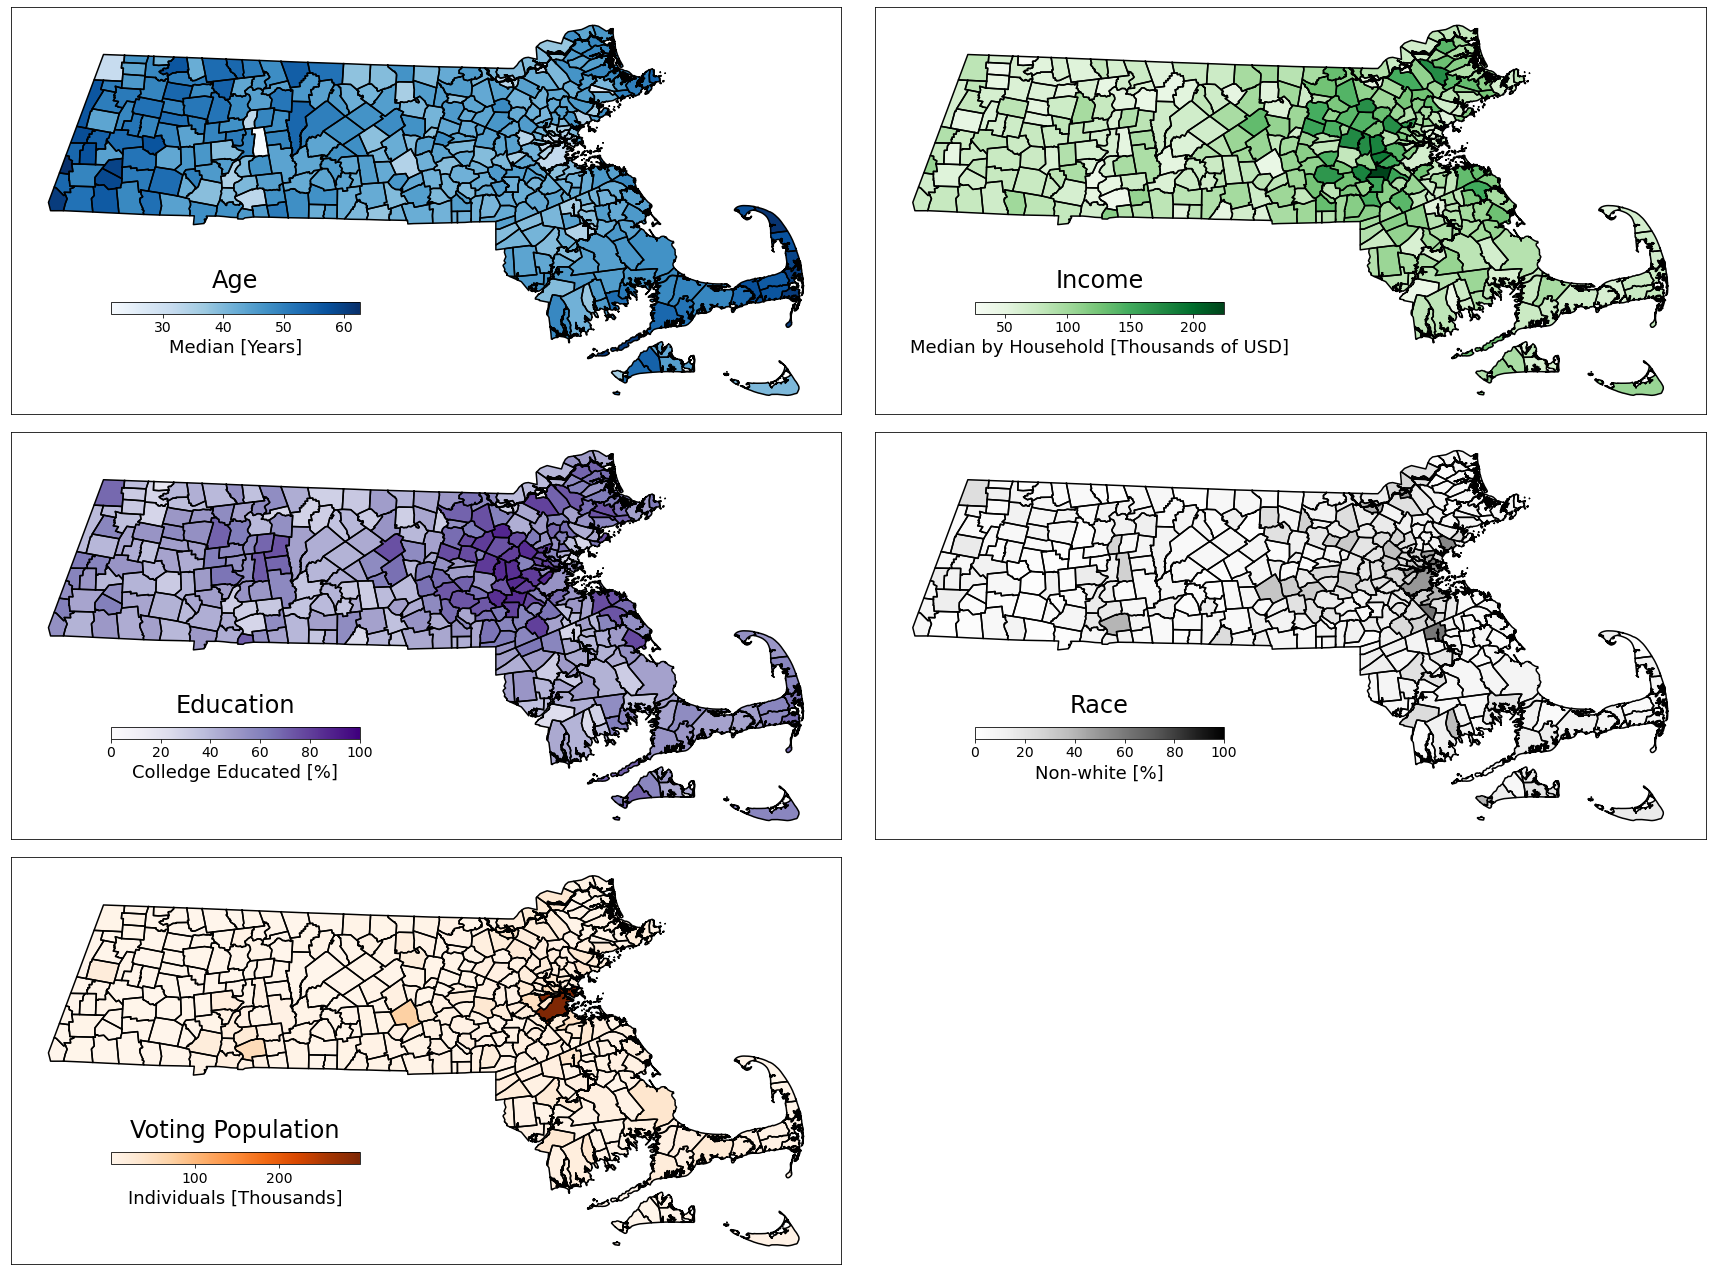

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(24,18))
plot_map_fill_multiple_ids("Age", massachusetts_shapes_index, massachusetts_shapes, color_vec = age_color_vec, legend = legend_age, ax = axs[0,0])
plot_map_fill_multiple_ids("Income", massachusetts_shapes_index, massachusetts_shapes, color_vec = income_color_vec, legend = legend_income, ax = axs[0,1])
plot_map_fill_multiple_ids("Education", massachusetts_shapes_index, massachusetts_shapes, color_vec = education_color_vec, legend = legend_education, ax = axs[1,0])
plot_map_fill_multiple_ids("Race", massachusetts_shapes_index, massachusetts_shapes, color_vec = race_color_vec, legend = legend_race, ax = axs[1,1])
plot_map_fill_multiple_ids("Voting Population", massachusetts_shapes_index, massachusetts_shapes, color_vec = population_color_vec, legend = legend_pop, ax = axs[2,0])
fig.delaxes(axs[2][1])

The demographic maps highlight some of the contrasts between urban and rural areas. Income, education, youth, minorities, and population are all concentrated in and around Boston.

# IV. Regression Analyses

## A. Univariate Analyses
The first step will be to see if the Ranked Choice Voting results are correlated with any of the demographic factors (Education, Income, Race, Age, Population) individually. However, as I expect partisanship (as reflected in Presidential voting behavior) to be a confounder, I'll also do univariate analyses against the other votes on the same ballot (President, Senate, Right to Repair)

In [24]:
# Build Dataset

education = []; income = []; race = []; age = []; voting_population = []; senate = []; Q1_RtR = []; Q2_RCV = []; president = []; w = [];
for town in Q2_No_fraction_by_town:
    education.append(normalized_education_by_town[town] * 100)
    income.append(raw_income_by_town[town] / 1000)
    race.append(minority_fraction_by_town[town] * 100)
    age.append(raw_age_by_town[town])
    voting_population.append(population[town])
    president.append((1 - president_fraction_by_town[town]) * 100)
    senate.append((1 - senate_fraction_by_town[town]) * 100)
    Q1_RtR.append((1 - Q1_No_fraction_by_town[town]) * 100)
    Q2_RCV.append((1 - Q2_No_fraction_by_town[town]) * 100)
    w.append(weights[town])

df = pd.DataFrame(list(zip(education, income, race, age, voting_population, president, senate, Q1_RtR, Q2_RCV, w)), 
               columns =['Education', 'Income', 'Race', 'Age', 'Population', 'President', 'Senate', 'Right to Repair', 'Ranked Choice Voting', 'Weights'])

y_frame = df[['Ranked Choice Voting']]
w_frame = df[['Weights']]
covariates = df[['Education', 'Income', 'Race', 'Age', 'Population', 'President','Senate', 'Right to Repair']]

In [25]:
def plot_scatter_and_model_fit(model_fit_dict,ax):
    
    # Load parameters and options
    x = model_fit_dict['x']
    y = model_fit_dict['y']
    w = model_fit_dict['w']
    predictions_wls = model_fit_dict['model_fit_values']
    xlabel = model_fit_dict['xlabel']
    ylabel = model_fit_dict['ylabel']
    str_loc_x = model_fit_dict['str_loc_x']
    str_loc_y = model_fit_dict['str_loc_y']
    
    # Make axes
    ax.tick_params(labelsize=18)
    ax.set_xlabel(xlabel,fontsize=24)
    ax.set_ylabel(ylabel,fontsize=24)
    
    # Scale weights for visualization
    w_plot = []
    w_plot = w * 300
    
    # Make text insert type 1: t and p values
    t = model_fit_dict['t']
    p = model_fit_dict['p']
    if t is not None and p is not None:
        if p < 0.001:
            p_str = 'p < 0.001'
        else:
            p_str = 'p = %.3f' % p 
        t_str = 't = %.1f' % t
        tp_strs = t_str + '\n' + p_str

        ax.text(str_loc_x, str_loc_y, tp_strs,
            horizontalalignment='left',
            transform=ax.transAxes,
            fontsize = 24)
    
    # Make text insert type 2: sentiment and polarization
    sentiment = model_fit_dict['sentiment']
    polarization = model_fit_dict['polarization']
    if sentiment is not None and polarization is not None:
        s_str = 'Sentiment = %.1f%%' % (sentiment * 100)
        p_str = 'Polarization = %.2f' % polarization 
        sp_strs = s_str + '\n' + p_str
        
        ax.text(str_loc_x, str_loc_y, sp_strs,
            horizontalalignment='left',
            transform=ax.transAxes,
            fontsize = 24)
        
    # Plot data and model fit
    ax.scatter(x, y, s=w_plot)
    ax.plot(x, predictions_wls, color='red')

In [26]:
scatter_plot_defaults = {}
scatter_plot_defaults['y'] = y_frame
scatter_plot_defaults['w'] = w_frame
scatter_plot_defaults['str_loc_x'] = .1
scatter_plot_defaults['str_loc_y'] = .8
scatter_plot_defaults['sentiment'] = None
scatter_plot_defaults['polarization'] = None

In [27]:
model_fits = []

### President

In [28]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['President']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'Biden Vote [%]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
print_model_president = model.summary()
# print(print_model_president)

model_fits.append(scatter_plot_dict)

### Senate

In [29]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Senate']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'Markey Vote [%]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
print_model = model.summary()
# print(print_model)

model_fits.append(scatter_plot_dict)

### Right to Repair

In [30]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Right to Repair']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'Right to Repair Vote [%]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
print_model = model.summary()
# print(print_model)

model_fits.append(scatter_plot_dict)

### Age

In [31]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Age']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'Median Age [Years]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
scatter_plot_dict['str_loc_x'] = .1
scatter_plot_dict['str_loc_y'] = .1
print_model = model.summary()
#print(print_model)

model_fits.append(scatter_plot_dict)

### Income

In [32]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Income']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'Median Household Income [Thousands of USD]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
scatter_plot_dict['str_loc_x'] = .7
scatter_plot_dict['str_loc_y'] = .1
print_model = model.summary()
#print(print_model)

model_fits.append(scatter_plot_dict)

### Education

In [33]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Education']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'College Educated [%]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
print_model = model.summary()
#print(print_model)

model_fits.append(scatter_plot_dict)

### Race

In [34]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Race']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r'Nonwhite [%]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
scatter_plot_dict['str_loc_x'] = .7
scatter_plot_dict['str_loc_y'] = .1
print_model = model.summary()
#print(print_model)

model_fits.append(scatter_plot_dict)

### Voting Population

In [35]:
scatter_plot_dict = scatter_plot_defaults.copy()
x_frame = df[['Population']]
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
scatter_plot_dict['x'] = x_frame / 1000
scatter_plot_dict['model_fit_values'] = model.predict(xx)
scatter_plot_dict['p'] = model.pvalues[1]
scatter_plot_dict['t'] = model.tvalues[1]
scatter_plot_dict['xlabel'] =  r' Voting Population [Thousands]'
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
scatter_plot_dict['str_loc_x'] = .7
scatter_plot_dict['str_loc_y'] = .1
print_model = model.summary()
#print(print_model)

model_fits.append(scatter_plot_dict)

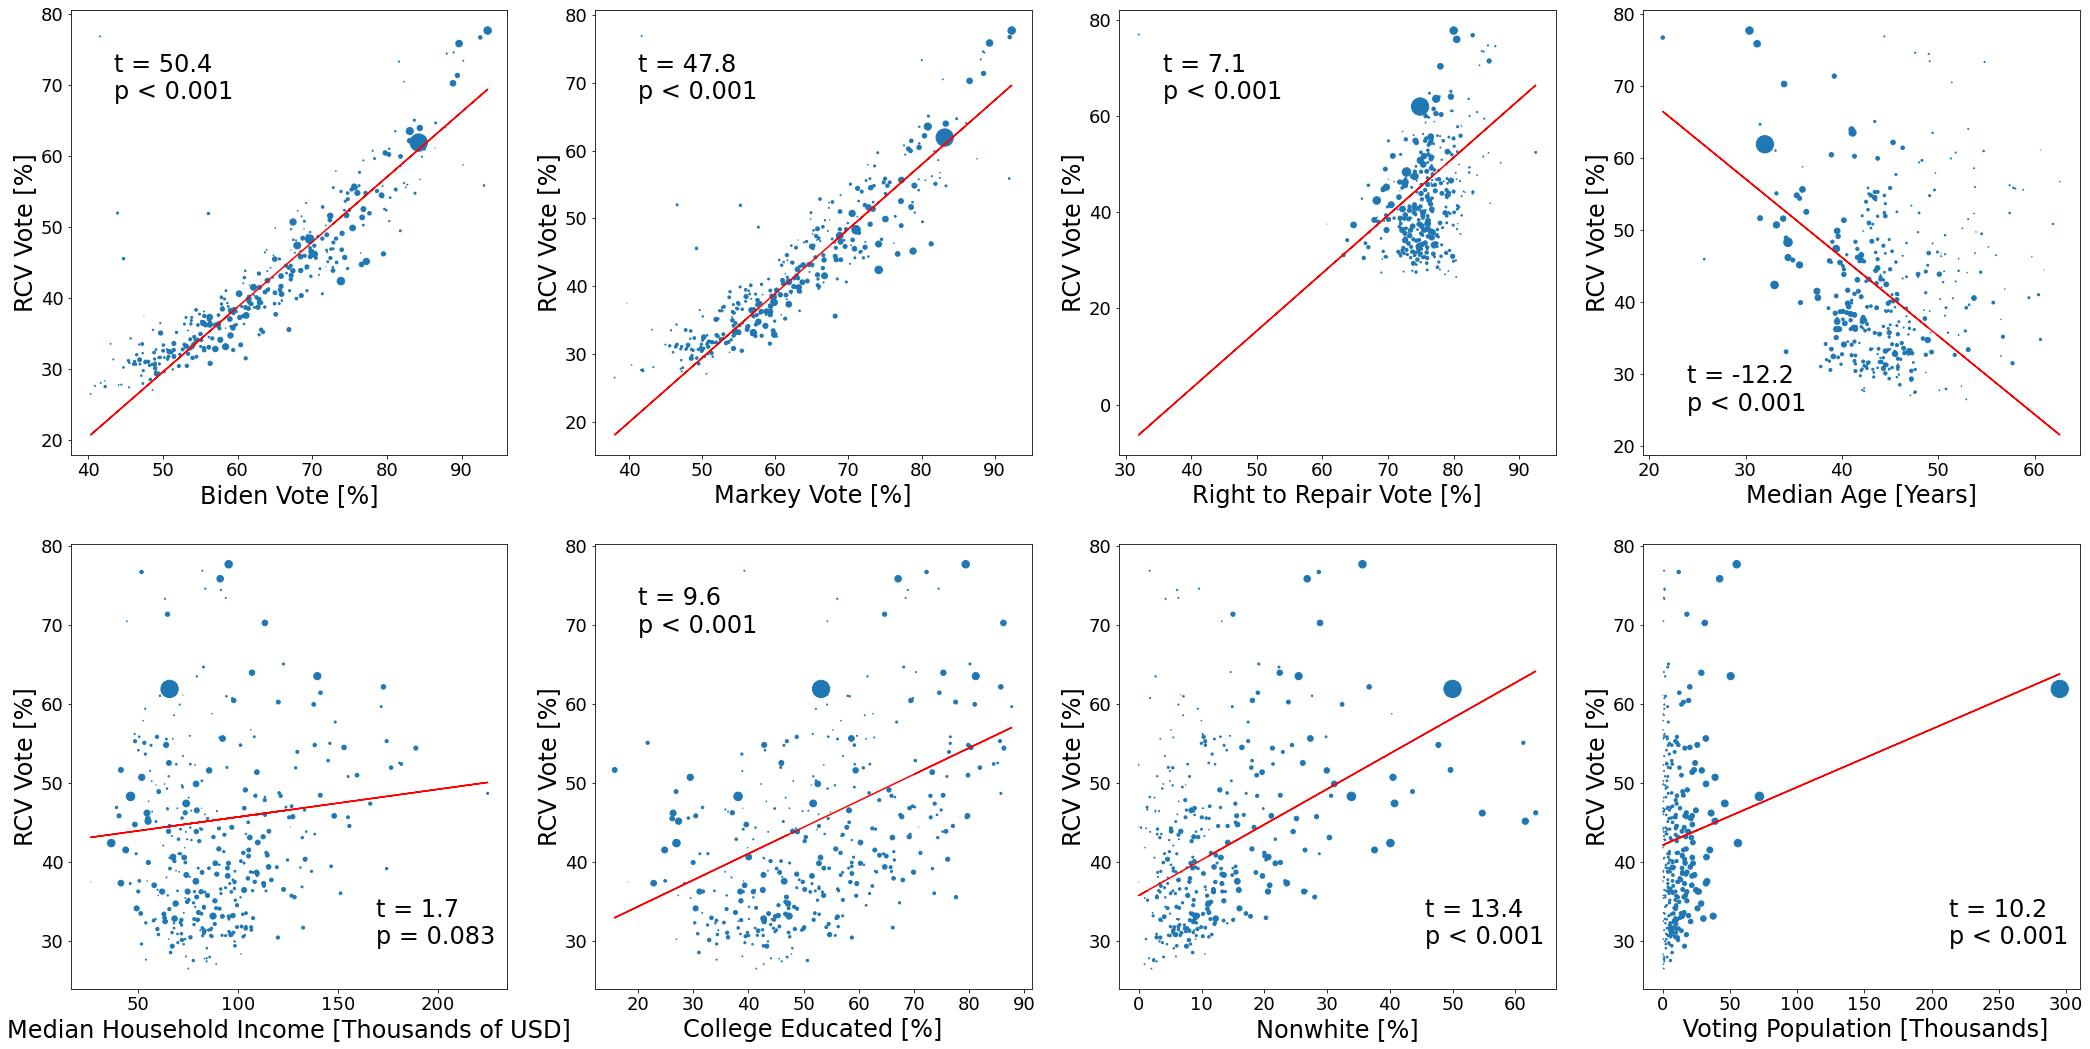

In [36]:
fig, axs = plt.subplots(2, 4, figsize=(36,18))

for r in range(0,2):
    for c in range(0,4):
        plot_scatter_and_model_fit(model_fits[4*r+c], axs[r,c])

In the univariate analyses, every factor except income was significantly (p < 0.05) correlated with RCV. We may, however, expect controlling for the other covariates to change which factors are significant. 

# B. Full Model
Now let's take a look at a multivariate model that includes all of the different covariates (with the exception of the senate vote because it is highly collinear with the presidential vote). In order to avoid some of the pitfalls that come with selecting covariates nonrigorously, I used the Purposeful Selection algorithm as described by [Bursac et al in 2008.](https://scfbm.biomedcentral.com/articles/10.1186/1751-0473-3-17)

## Building Purposeful Selection

In [37]:
# Step 1: Univariate Fits
# Compare univariate pvalues to PVALUEI and select covariates for initial multivariate fit

# Recommended values
PVALUEI = 0.25
PVALUER = 0.1
CHBETA = 15
PVALUE = 0.15

# Values suitable for testing
#PVALUEI = 0.001
#PVALUER = 0.00001
#CHBETA = 50
#PVALUENC = 0.9


initial_covariates = covariates.drop(columns = ['Senate'])

# Do univariate fits and get p-values
uni_pvalues = {}
cols = initial_covariates.columns
for col in cols:
    x_frame = initial_covariates[[col]]
    xx = sm.add_constant(x_frame) # adding a constant
    model = sm.WLS(y_frame, xx, w_frame).fit()
    uni_pvalues[col] = model.pvalues[1]

included_covariates = pd.DataFrame()
excluded_covariates = pd.DataFrame()
for i in range(0,len(cols)):
    covariate_name = cols[i]
    if uni_pvalues[covariate_name] < PVALUEI:
        included_covariates[covariate_name] = initial_covariates[covariate_name]
    else:
        excluded_covariates[covariate_name] = initial_covariates[covariate_name]
        print('Removing %s!\n' % covariate_name)

In [38]:
def reduce_model(included_covariates, locked_covariates, y_frame, w_frame):

    # Multivariate fit
    current_covariates = pd.concat([included_covariates,locked_covariates],axis = 1)
    final_model = False

    while not final_model: # Loop A
        cols = current_covariates.columns
        x_frame = current_covariates
        xx = sm.add_constant(x_frame) # adding a constant
        model = sm.WLS(y_frame, xx, w_frame).fit()
        fit_pvalues = model.pvalues
        fit_pvalues = fit_pvalues.drop('const')
        fit_pvalues = fit_pvalues.sort_values(ascending = False)
        betas = model.params
        betas = betas.drop('const')


        # Drop locked covariates
        for i in range(0,len(locked_covariates.keys())):
            fit_pvalues = fit_pvalues.drop(locked_covariates.keys()[i])

        for i in range(0,len(fit_pvalues)): # Loop B
            covariate_to_remove = fit_pvalues.keys()[i]
            pvalue = fit_pvalues[i]
            #print(covariate_to_remove)
            #print(pvalue)
            #print('\n')

            if pvalue > PVALUER:
                # New model
                covariate_to_remove = fit_pvalues.keys()[i]
                any_impact = check_for_beta_changes(betas, current_covariates, y_frame, w_frame, covariate_to_remove)

                print('Removing %s had an impact: %s\n' % (covariate_to_remove, any_impact))

                if not any_impact:
                    current_covariates = current_covariates.drop(columns = covariate_to_remove)
                    print('Removing %s!' % covariate_to_remove)
                    break

        final_model = True

    return(current_covariates)

In [39]:
def check_for_beta_changes(betas = None, current_covariates = None, y_frame = None, w_frame = None, covariate_to_remove = None):
    new_covariates = current_covariates.drop(columns = covariate_to_remove)
    
    # New model
    x_frame = new_covariates
    xx = sm.add_constant(x_frame) # adding a constant
    new_model = sm.WLS(y_frame, xx, w_frame).fit()
    print_model = new_model.summary()
    #print(print_model)
    new_betas = new_model.params
    new_betas = new_betas.drop('const')
    
    any_impact = False
    for covariate in new_covariates:
        chbeta = new_betas[covariate] / betas[covariate]
        if np.abs(1 - chbeta) * 100 > CHBETA:
            any_impact = True
    return any_impact

In [40]:
# Step 2: Reduce Model
locked_covariates = pd.DataFrame()
locked_covariates = reduce_model(included_covariates, locked_covariates, y_frame, w_frame)

Removing Income had an impact: False

Removing Income!


In [41]:
# Step 3: test non-candidate covariates
new_covariates = pd.DataFrame()
for i in range(0,len(excluded_covariates.keys())):
    covariate_name = excluded_covariates.keys()[i]
    
    print(covariate_name)
     # Multivariate fit
    current_covariates = pd.concat([excluded_covariates,locked_covariates],axis = 1)
    
    cols = current_covariates.columns
    x_frame = current_covariates
    xx = sm.add_constant(x_frame) # adding a constant
    model = sm.WLS(y_frame, xx, w_frame).fit()
    fit_pvalues = model.pvalues

    pvalue = fit_pvalues[covariate_name]

    if pvalue < PVALUENC:
        print('Adding back in %s' % covariate_name)
        new_covariates = pd.concat([new_covariates,excluded_covariates[covariate_name]],axis = 1)
        

In [42]:
# Step 4: Reduce model again
final_covariates = reduce_model(new_covariates, locked_covariates, y_frame, w_frame)

In [43]:
# Display final model
x_frame = final_covariates
xx = sm.add_constant(x_frame) # adding a constant
model = sm.WLS(y_frame, xx, w_frame).fit()
print_model = model.summary()
print(print_model)

                             WLS Regression Results                             
Dep. Variable:     Ranked Choice Voting   R-squared:                       0.909
Model:                              WLS   Adj. R-squared:                  0.908
Method:                   Least Squares   F-statistic:                     574.4
Date:                  Thu, 31 Dec 2020   Prob (F-statistic):          7.09e-176
Time:                          16:23:23   Log-Likelihood:                -1057.1
No. Observations:                   351   AIC:                             2128.
Df Residuals:                       344   BIC:                             2155.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -12.

After discarding the senate vote as a covariate for being too similar to the presidential vote (collinear), and Purposeful Selection removing income, we are left with a model that features six covariates: education, race, age, population, presidential vote, and right to repair vote. According to this model, even after controlling for all the other covariates present, each has a statistically significant effect (p < 0.05) with the exception of population.

Looking at the coefficient column of the table, we can see that for every additional 5% points of Biden vote share in a municipality, the model predicts an additional 4% points of vote share for RCV. That's a fairly strong effect. Going down the list, we have an additional 1% RCV vote share for every 2 year decrease in median age, for every additional 3% points of right to repair vote share, every additional 20% share in college educated population, and every additional 20% share in white population. Needing 20% differences in education and race to account for a 1% change in RCV share suggests that these are fairly weak effects, even if they are statistically significant. The other significant covariates (presidential vote, age, right to repair vote) appear to be stronger predictors.

On the other hand, how does this full model compare to the simpler ones we looked at up front? If we examine the univariate presidential vote model (below), we can compare some of the model performance metrics. The R-squared value of the univariate model indicates that the presidential vote explains 88% of the variance in the fit of the RCV data. For comparison, the full model only explains an additional 2% (90%) of the variance. Furthermore, both the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) are lower (and lower is better) for the univariate presidential vote model than for the full model. This indicates that the added explanatory power of the additional covariates may not be worth the cost of having them in the model in the first place.

We should therefore be hesitant to draw strong conclusions regarding any covariates aside from the revealed partisanship reflected in the presidential vote (and senate vote).

In [44]:
# And for comparison the univariate analysis with the presidential vote:
print(print_model_president)

                             WLS Regression Results                             
Dep. Variable:     Ranked Choice Voting   R-squared:                       0.879
Model:                              WLS   Adj. R-squared:                  0.879
Method:                   Least Squares   F-statistic:                     2541.
Date:                  Thu, 31 Dec 2020   Prob (F-statistic):          2.89e-162
Time:                          16:23:22   Log-Likelihood:                -1107.2
No. Observations:                   351   AIC:                             2218.
Df Residuals:                       349   BIC:                             2226.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.2640      1.240

# V. Describing Other Results in Terms of Presidential Vote

The strong linear correlations of all the 2020 Massachusetts ballot decisions raises another possibility. If you know the results of the presidential vote, you can describe the other three votes in terms of only two other degrees of freedom (slope and intercept). 

In [45]:
model_fits2 = []
w = []; z = [];
for town in Q2_No_fraction_by_town:
    w.append(weights[town])
    z.append((1 - president_fraction_by_town[town])*weights[town])
median_Biden_vote = sum(z)/sum(w)

In [46]:
scatter_plot_defaults2 = {}
x_frame = df[['President']]
scatter_plot_defaults2['x'] = x_frame
scatter_plot_defaults2['y'] = y_frame
scatter_plot_defaults2['w'] = w_frame
scatter_plot_defaults2['xlabel'] =  r'Presidential Vote [%]'
scatter_plot_defaults2['str_loc_x'] = .55
scatter_plot_defaults2['str_loc_y'] = .1
scatter_plot_defaults2['p'] = None
scatter_plot_defaults2['t'] = None

In [47]:
# Plot Senate results against Presidential results
scatter_plot_dict = scatter_plot_defaults2.copy()
y = df[['Senate']]
xx = sm.add_constant(x_frame) # adding a constant
sen_model = sm.WLS(y, xx, w_frame).fit()
scatter_plot_dict['y'] = y * 100
scatter_plot_dict['ylabel'] =  r'Senate Vote [%]'
scatter_plot_dict['model_fit_values'] = sen_model.predict(xx) * 100
scatter_plot_dict['sentiment'] = sen_model.predict([1,median_Biden_vote]) [0]
scatter_plot_dict['polarization'] = sen_model.params[1]

model_fits2.append(scatter_plot_dict)

In [48]:
# Plot Right to Repair against presidential results
scatter_plot_dict = scatter_plot_defaults2.copy()
y = df[['Right to Repair']]
xx = sm.add_constant(x_frame) # adding a constant
Q1_model = sm.WLS(y, xx, w_frame).fit()
predictions_wls = Q1_model.predict(xx) 
scatter_plot_dict['y'] = y * 100
scatter_plot_dict['ylabel'] =  r'Right to Repair Vote [%]'
scatter_plot_dict['model_fit_values'] = predictions_wls * 100
scatter_plot_dict['sentiment'] = Q1_model.predict([1,median_Biden_vote])[0]
scatter_plot_dict['polarization'] = Q1_model.params[1]

model_fits2.append(scatter_plot_dict)

In [49]:
# Plot Ranked Choice Voting results against Presidential results
scatter_plot_dict = scatter_plot_defaults2.copy()
y = df[['Ranked Choice Voting']]
xx = sm.add_constant(x_frame) # adding a constant
Q2_model = sm.WLS(y, xx, w_frame).fit()
predictions_wls = Q2_model.predict(xx) 
scatter_plot_dict['y'] = y * 100
scatter_plot_dict['ylabel'] =  r'RCV Vote [%]'
scatter_plot_dict['model_fit_values'] = predictions_wls * 100
scatter_plot_dict['sentiment'] = Q2_model.predict([1,median_Biden_vote]) [0]
scatter_plot_dict['polarization'] = Q2_model.params[1]

model_fits2.append(scatter_plot_dict)

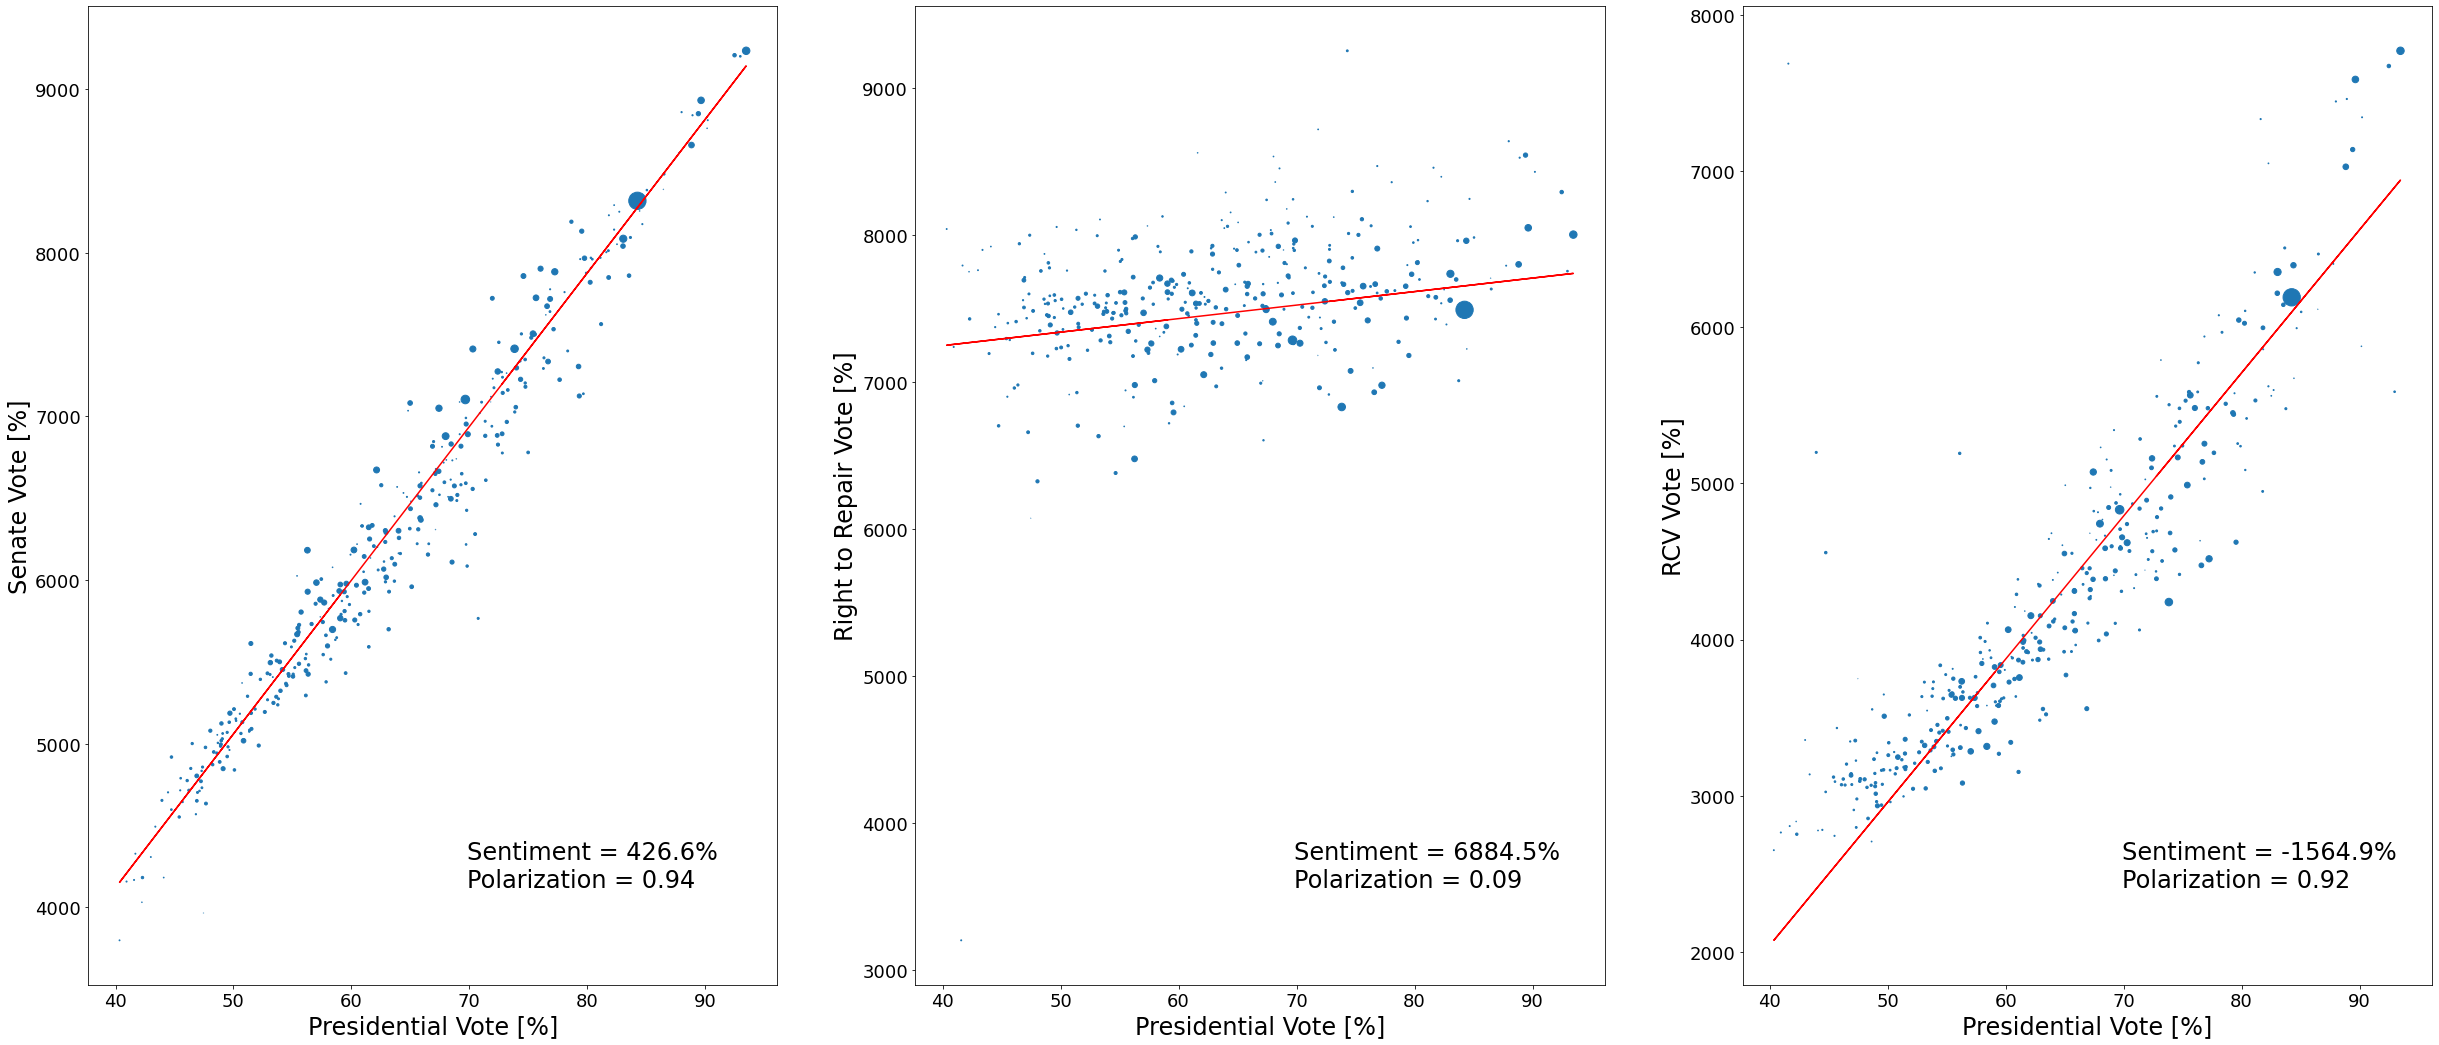

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(42,18))

for i in [0,1,2]:
    plot_scatter_and_model_fit(model_fits2[i], axs[i])

The slope of the fit line in each of the above plots reflects how much variation there was across the state in each vote relative to the presidential vote. For example, in both the presidential and senate races, the vote share for each municipality ranged roughly from 40% to 90%, creating a slope fairly close to 1. The right to repair vote, on the other hand, fell within a much tighter range, between 70% and 80%. Relative to the senate plot, this leads to a much lower slope value (about 1/10). Therefore, we can consider the slope of the fit line to be an index of issue polarization relative to that of the presidential vote. The senate and RCV votes were fairly highly polarized issues while the right to repair initiative had remarkably low polarization.

Then, rather than using the y-intercept to describe the fit lines (as is mathematically most convenient), we can instead select a point with greater significance. The fit value of the municipality with the median presidential vote share should approximate the overall result of the non-presidential vote (senate, right to repair, or RCV). This gives us a description of the overall sentiment about a vote. It will not, of course, correspond to the exact value of the statewide vote share because it is a model fit, not a tally.

# VI. Discussion

So where does this leave us? Well, we still don't know what drives the difference in sentiment between the presidential vote and the RCV vote. But we do know that RCV was highly polarizing and that its shortfall relative to Biden's performance was a statewide phenomenon and not specific to any region.

A limitation of this analysis is that it doesn't produce any strategic or tactical recommendations for future Ranked Choice Voting campaigns. It is also possible that there may be other or better explanatory factors that I failed to consider.

For possible future directions, it would be interesting to see if the strong correlations between votes hold for previous elections and if they can also be well-described in terms of 2020 partisanship. For example, would the data for the 2018 [Gender Identity Anti-Discrimination Veto Referendum](https://ballotpedia.org/Massachusetts_Question_3,_Gender_Identity_Anti-Discrimination_Veto_Referendum_(2018)) ("Transgender Bathroom Bill") determine it to be both highly supported and highly polarizing? It would also be interesting to look at neighboring towns in neighboring states (NH, VT, NY, CT, RI) to see if there is continuity in the presidential voting patterns. And while the [local politics in Alaska](https://www.adn.com/politics/alaska-legislature/2019/02/14/alaska-house-deadlock-ends-with-rep-edgmon-elected-speaker/) differ greatly from those in Massachusetts, it would be interesting to see what might be gleaned from another successful RCV initiative in the same election cycle.